In [1]:
#https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist

In [2]:
import pathlib

path=str(pathlib.Path().resolve())+"/data/"

In [3]:
import math
import os
import numpy as np
import cv2 as cv
import random
import librosa

def get_data(path,sr):
    """Devuelve los audios,audiosRate y los valores

    Args:
        path (str): Carpeta donde se encuentra los audios
        sr (int): sr

    Returns:
        List: Lista de audios, audiosRate y los valores
    """
    audios = []  # Lista para audios
    audiosRate = []  # Lista para audiosRate
    values = []  # Lista para las etiquetas
    print(path)
    for audio in os.listdir(path):
        samples, sample_rate = librosa.load(path+"/"+audio, sr=None, mono=False)
        audios.append(np.array(transform_sample(samples,sr,sample_rate)))
        audiosRate.append(sample_rate)
        values.append(audio.split("_")[0])
    
    return np.array(audios),np.array(audiosRate),np.array(values) 

def transform_sample(sample,sr,sample_rate):
    """Transforma los audios y les añade desplazamiento, duración, ruido ...

    Args:
        sample (audio): audio
        sr (int): sr
        sample_rate (int): El ratio

    Returns:
        _type_: Audio transformado
    """
    samples=librosa.to_mono(sample)
    sample_trunc = seconds(1000,librosa.resample(samples,orig_sr=sample_rate,target_sr=sr),sr)
    sample_shift = desplazamiento(0.1,sample_trunc)
    return noise(50,sample_shift)

def seconds(x,sampl,sr):
    sig_len = sampl.shape[0]
    max_len = (sr//1000) * x

    if sig_len >= max_len: # truncar
      samples_trunc = sampl[:max_len]
    else: # expandir con ceros
      z = np.zeros(max_len - sig_len)
      samples_trunc = np.concatenate((sampl,z))
    return samples_trunc

def desplazamiento(shift_limit,sample):
    sig_len = sample.shape[0]
    shift_len = int(shift_limit * sig_len)
    return np.roll(sample, shift_len)

def noise(SNR,sample):
    RMS_s = math.sqrt(np.mean(sample**2)) # rms
    RMS_n = math.sqrt(RMS_s**2/(pow(10, SNR/10))) # rms deseado del ruido
    noise = np.random.normal(0, RMS_n, sample.shape[0]) # normal media 0 y desviación std RMS_n
    return sample + noise

In [4]:
from concurrent.futures import ThreadPoolExecutor

dirs = os.listdir(path)
threadList=[]
audios,values,rates=[],[],[]
with ThreadPoolExecutor() as executor:
    """Crea una Pool de Hilos para ejecutarlos a destiempo y que no tarde demasiado la ejecución
    """
    sr = 22050
    for dir in dirs:
        if dir.endswith(".txt"):continue
        threadList.append(executor.submit(get_data,path+dir,sr))

    for t in threadList:
        r=t.result()
        audios.append(r[0])
        rates.append(r[1])
        values.append(r[2])

audios = np.array(audios)
rates = np.array(rates)
values = np.array(values)

C:\Users\diego.guizanlopez\Documents\BigDataEIa\IA\Sistemas_Aprendizaje_Automatico\3-Trimestre\Redes_Neuronales\Clasificacion_Sonido\Audio_Mnist/data/01
C:\Users\diego.guizanlopez\Documents\BigDataEIa\IA\Sistemas_Aprendizaje_Automatico\3-Trimestre\Redes_Neuronales\Clasificacion_Sonido\Audio_Mnist/data/02
C:\Users\diego.guizanlopez\Documents\BigDataEIa\IA\Sistemas_Aprendizaje_Automatico\3-Trimestre\Redes_Neuronales\Clasificacion_Sonido\Audio_Mnist/data/03
C:\Users\diego.guizanlopez\Documents\BigDataEIa\IA\Sistemas_Aprendizaje_Automatico\3-Trimestre\Redes_Neuronales\Clasificacion_Sonido\Audio_Mnist/data/04
C:\Users\diego.guizanlopez\Documents\BigDataEIa\IA\Sistemas_Aprendizaje_Automatico\3-Trimestre\Redes_Neuronales\Clasificacion_Sonido\Audio_Mnist/data/05
C:\Users\diego.guizanlopez\Documents\BigDataEIa\IA\Sistemas_Aprendizaje_Automatico\3-Trimestre\Redes_Neuronales\Clasificacion_Sonido\Audio_Mnist/data/06
C:\Users\diego.guizanlopez\Documents\BigDataEIa\IA\Sistemas_Aprendizaje_Automatico

In [5]:
#from matplotlib import pyplot as plt
#
#
#plt.figure(figsize=(14,5))
#plt.plot(audios[0][0])

In [6]:
#audios

Aplanamos los Arrays para tener un shape normal en los audios,rates y values

In [7]:
audios=audios.reshape(-1, audios.shape[-1])
rates=rates.flatten()
values=values.flatten()

In [29]:
from IPython.display import Audio
Audio(audios[0],rate=rates[0])

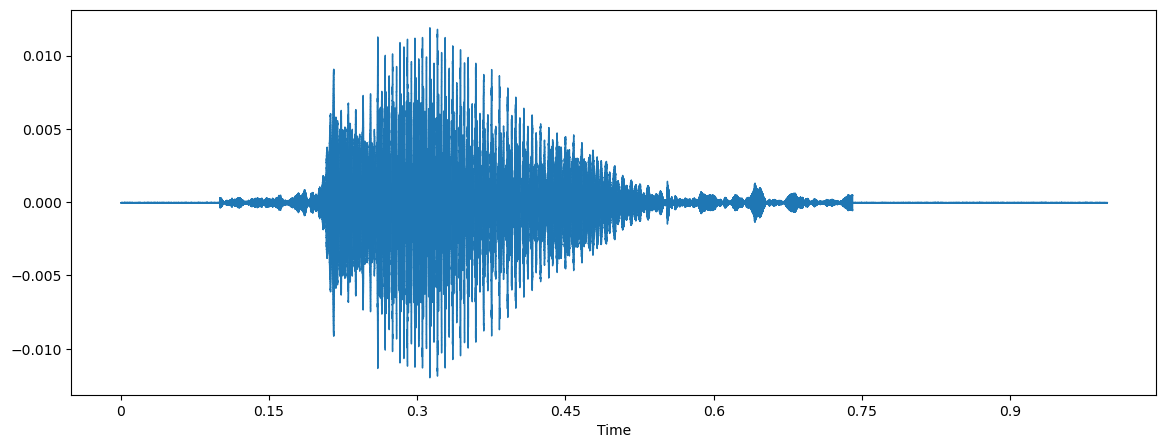

In [30]:
from matplotlib import pyplot as plt


plt.figure(figsize=(14,5))
librosa.display.waveshow(audios[0], sr=sr)

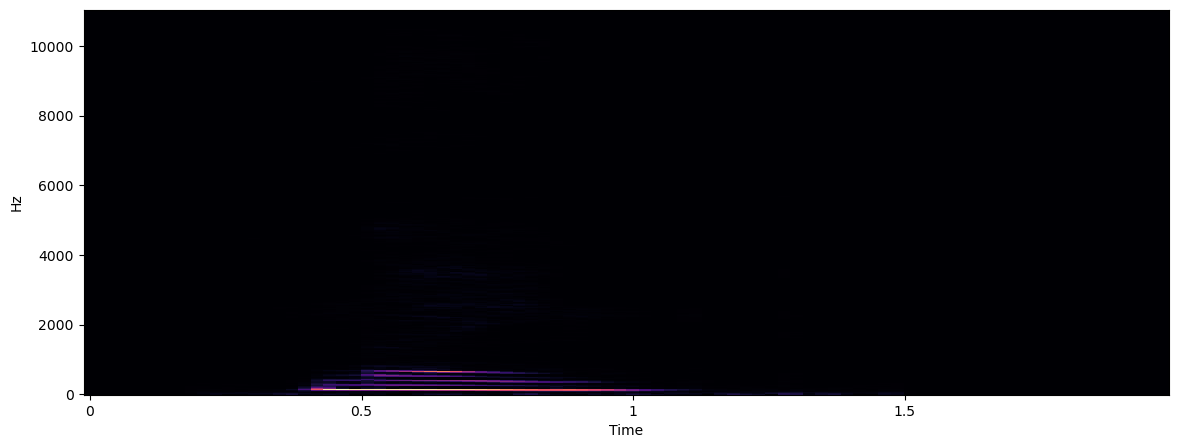

In [31]:
sgram = librosa.stft(audios[0], n_fft=1024, hop_length=None)
sgram, _ = librosa.magphase(sgram)
plt.figure(figsize=(14,5))
librosa.display.specshow(sgram,sr=sr,x_axis="time",y_axis="hz")

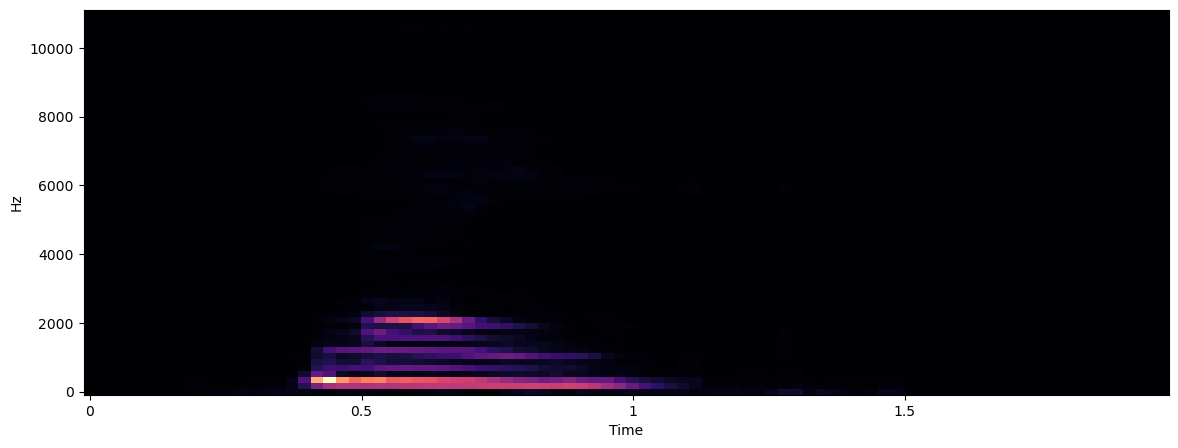

In [32]:
sgram = librosa.feature.melspectrogram(S=sgram, sr=sr, n_mels=64)
plt.figure(figsize=(14,5))
librosa.display.specshow(sgram, sr=sr, x_axis="time", y_axis="hz")

Vemos un ejemplo de espectograma donde le ponemos dos líneas negras para probar

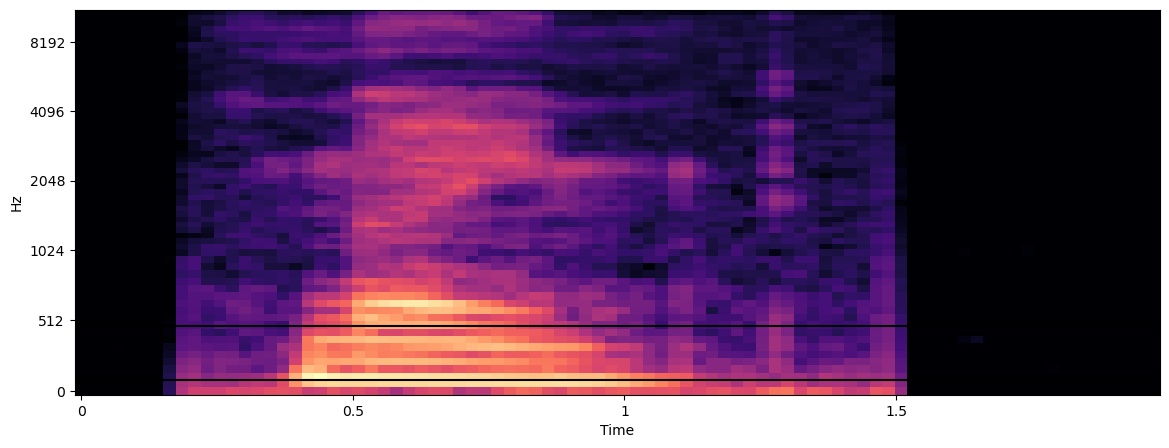

In [33]:
sgram = librosa.amplitude_to_db(sgram, ref=np.min)
plt.figure(figsize=(14,5))
y = np.random.randint(0,8192)
plt.axline((0,y),(1.75,y),c="Black")
y = np.random.randint(0,8192)
plt.axline((0,y),(1.75,y),c="Black")
#plt.plot(x1, y1, x2, y2, marker = 'o')
librosa.display.specshow(sgram, sr=sr, x_axis="time", y_axis="mel")

In [34]:
concate = list(zip(audios,values))
random.shuffle(concate)
audios,values = list(zip(*concate))

In [35]:
def convert_image(audio,index):
    sgram = librosa.stft(audio, n_fft=1024, hop_length=None)
    sgram, _ = librosa.magphase(sgram)
    #librosa.display.specshow(sgram,sr=sr,x_axis="time",y_axis="hz")
    sgram = librosa.feature.melspectrogram(S=sgram, sr=sr, n_mels=64)
    #librosa.display.specshow(sgram, sr=sr, x_axis="time", y_axis="hz")
    sgram = librosa.amplitude_to_db(sgram, ref=np.min)
    #y = np.random.randint(0,8192)
    #plt.axline((0,y),(1.75,y),c="Black")
    #y = np.random.randint(0,8192)
    #plt.axline((0,y),(1.75,y),c="Black")
    #plt.figure(figsize=(14,5))
    #librosa.display.specshow(sgram, sr=sr, x_axis="time", y_axis="mel")
    #print(index)
    return sgram

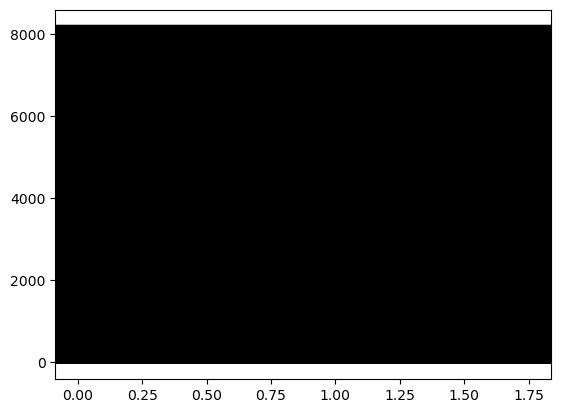

In [36]:
X=np.array([convert_image(x,index) for index,x in enumerate(audios)])

In [37]:
y=np.array(values,dtype=np.int64)

Creamos un Label Encoder para que adapte los valores de y en su rango de [0-X)

In [38]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(y)

In [39]:
#X=audios


In [40]:
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import to_categorical

Dividimos los valores de train,test y validación

In [41]:
from sklearn.model_selection import train_test_split

X_train_full, X_test , y_train_full, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val , y_train, y_val = train_test_split(X_train_full,y_train_full,test_size=0.2,random_state=42)

Creamos un modelo secuencial de la siguiente estructura:
- 2X Conv2D (32,(3,3))
- MaxPooling2D (2,2)
- 2X Conv2D (64,(3,3))
- Flatten
- Dense (64)
- Dense (longitud de valores únicos de Y)

In [42]:
model = models.Sequential()

# Va hacer 32 Kernels que serán 3X3 es decir
# Recogera de cada 3 pixeles el central para la nueva imagen 
# Podríamos indicar los Strides (1,1) que son las casillas que avanza
# Le decimos que sea 28 x 28 y que tenga un canal
model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(X_train.shape[1],X_train.shape[2],1)))
model.add(layers.Conv2D(32,(3,3),activation="relu"))

# Se va reduciendo la imagen por lo que podemos aumentar el número de filtros, donde la imagen se nos va a la mitad
model.add(layers.MaxPooling2D((2,2)))

# Lo normal es aumentar el número de filtros en la imagen
model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.Conv2D(64,(3,3),activation="relu"))
#model.add(layers.MaxPooling2D((2,2)))

# Aplana la capa actual
#model.add(layers.Conv2D(128,(3,3),activation="relu"))
#model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.Flatten())

model.add(layers.Dense(64,activation="relu"))
model.add(layers.Dense(len(np.unique(y)),activation="softmax"))

model.summary()

c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\deep-learning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 62, 84, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 82, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 41, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 39, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 26, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61568)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     3,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,006,058 (15.28 MB)

 Trainable params: 4,006,058 (15.28 MB)

 Non-trainable params: 0 (0.00 B)

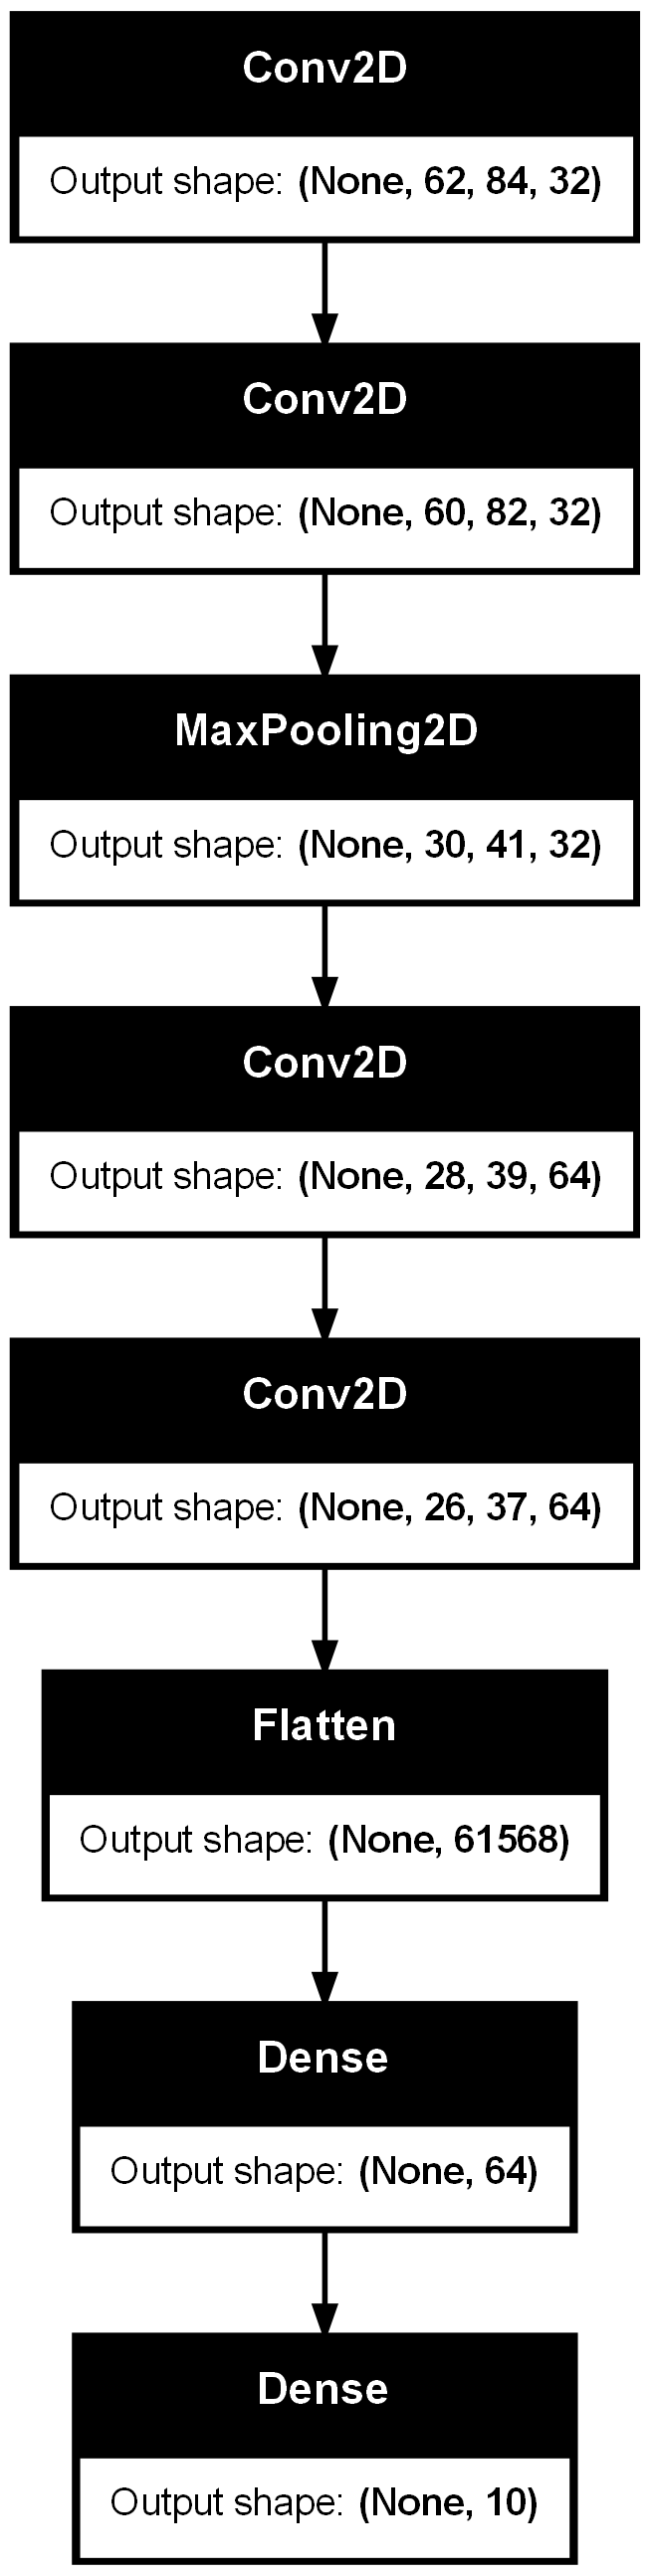

In [43]:
keras.utils.plot_model(model, "audio_model.png", show_shapes=True)

Compilamos el modelo como sparse_categorical_crossentropy y el optimizador deseado es Adam, le decimos que la métrica es el Accuracy

In [44]:
model.compile(loss="sparse_categorical_crossentropy",  optimizer="adam",   metrics=["accuracy"])

Entrenamos el modelo con un EarlyStopping para que detecte cuando parar con una paciencia de 2

In [45]:

import sys

early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)

history = model.fit(X_train,y_train,epochs=sys.maxsize,validation_data=(X_val,y_val),callbacks=[early_stopping_cb])

Epoch 1/9223372036854775807
600/600 ━━━━━━━━━━━━━━━━━━━━ 71s 114ms/step - accuracy: 0.8189 - loss: 1.0545 - val_accuracy: 0.9660 - val_loss: 0.1224
Epoch 2/9223372036854775807
600/600 ━━━━━━━━━━━━━━━━━━━━ 67s 112ms/step - accuracy: 0.9857 - loss: 0.0494 - val_accuracy: 0.9798 - val_loss: 0.0606
Epoch 3/9223372036854775807
600/600 ━━━━━━━━━━━━━━━━━━━━ 67s 112ms/step - accuracy: 0.9924 - loss: 0.0262 - val_accuracy: 0.9800 - val_loss: 0.0613
Epoch 4/9223372036854775807
600/600 ━━━━━━━━━━━━━━━━━━━━ 65s 108ms/step - accuracy: 0.9875 - loss: 0.0419 - val_accuracy: 0.9898 - val_loss: 0.0335
Epoch 5/9223372036854775807
600/600 ━━━━━━━━━━━━━━━━━━━━ 67s 112ms/step - accuracy: 0.9957 - loss: 0.0125 - val_accuracy: 0.9946 - val_loss: 0.0282
Epoch 6/9223372036854775807
600/600 ━━━━━━━━━━━━━━━━━━━━ 63s 106ms/step - accuracy: 0.9971 - loss: 0.0116 - val_accuracy: 0.9879 - val_loss: 0.0486
Epoch 7/9223372036854775807
600/600 ━━━━━━━━━━━━━━━━━━━━ 64s 107ms/step - accuracy: 0.9980 - loss: 0.0093 - val_

Mostramos el histograma para ver como fue

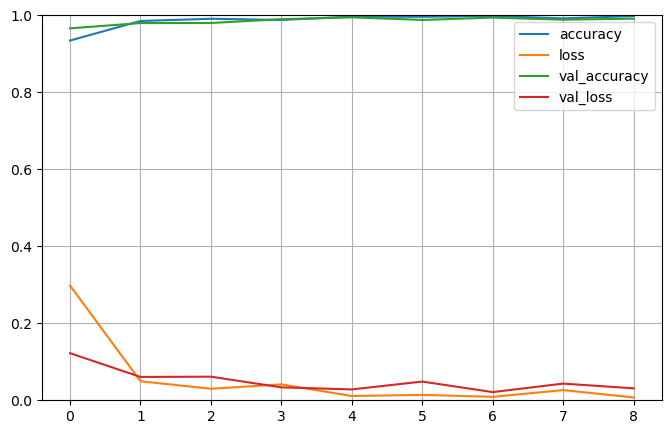

In [46]:
import pandas as pd


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Evaluamos el modelo para ver los resultados

In [47]:
model.evaluate(X_test,y_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9927 - loss: 0.0248


[0.03200756758451462, 0.9923333525657654]

Predecimos los valores del modelo para ver los resultados

In [48]:
y_test_pred = model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = y_test

188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


Y por último mostramos los resultados en una matriz de confusión, viendo que el resultado es muy correcto y tiene una tasa de Accuracy bastante grande

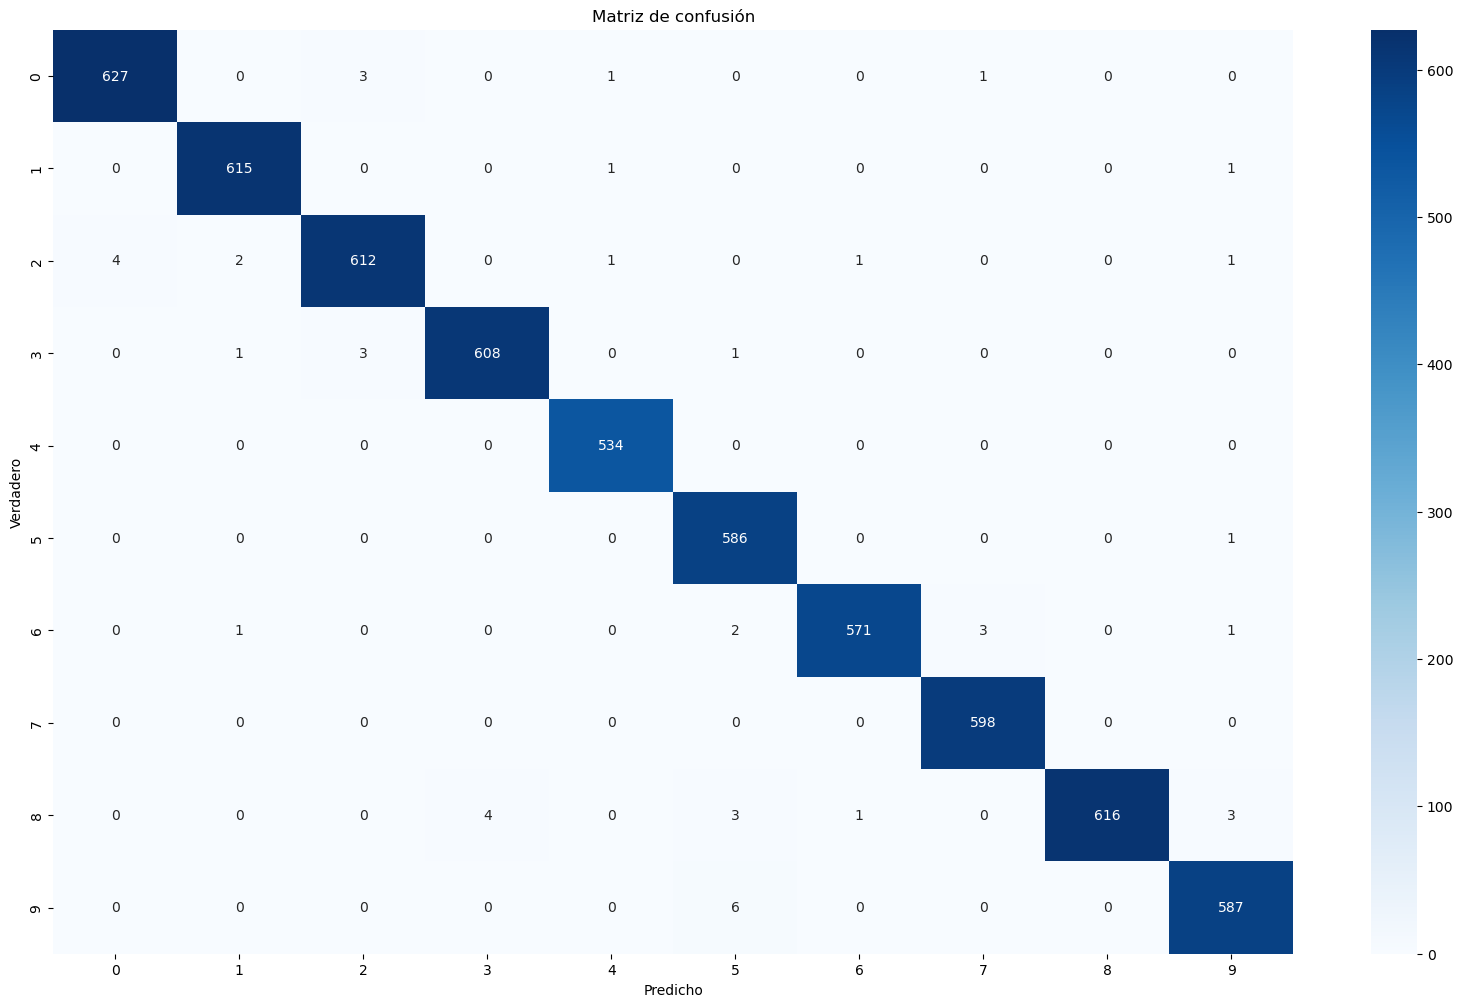

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_true_labels, y_test_pred_labels)

plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.title('Matriz de confusión')
plt.show()